In [1]:
# optimizer(SGD, Momentum, AdaGrad, Adam)

In [2]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr

    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

In [3]:
import numpy as np
import os, sys

os.chdir(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-master\ch04")
sys.path.append(os.pardir)
# from dataset.mnist import load_mnist
# from common.functions import softmax, cross_entropy_error, sigmoid, sigmoid_grad
# from common.gradient import numerical_gradient
from common.layers import Relu, Sigmoid, Affine, SoftmaxWithLoss
from collections import OrderedDict

class TwoLayerNet_v3:

    def __init__(self, input_size, hidden_size, output_size, weight_init_std = 0.01):
        # 重みの初期化
        self.params = {}
        self.params['W1'] = weight_init_std * np.random.randn(input_size, hidden_size)
        self.params['b1'] = np.zeros(hidden_size)
        self.params['W2'] = weight_init_std * np.random.randn(hidden_size, output_size)
        self.params['b2'] = np.zeros(output_size)

        # レイヤの生成
        self.layers = OrderedDict()
        self.layers['Affine1'] = Affine(self.params['W1'], self.params['b1'])
        self.layers['Relu1'] = Relu()
        self.layers['Affine2'] = Affine(self.params['W2'], self.params['b2'])

        self.lastLayer = SoftmaxWithLoss()

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x


    # x:入力データ, t:教師データ
    def loss(self, x, t):
        y = self.predict(x)
        return self.lastLayer.forward(y, t) #SoftmaxWithLossのforward計算（損失計算）

    # 逆伝播を使った勾配計算
    # numerical_gradient_multiDim & Allnumerical_gradientsより高速に勾配が求められる(backward propagationが組み込まれているから)
    def gradient(self, x, t):
        # forward
        self.loss(x,t) #まず損失計算されることでSoftmaxWithLossクラス内のself.yとself.tが格納される（backwardで使われる）

        #backward
        dout = 1
        dout = self.lastLayer.backward(dout) #self.yとself.tを使って計算
        # 残りのレイヤーを逆順で逆伝播計算し、その際に各Affineレイヤー内の勾配(dW,db)が計算されていく
        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)
        #各Affineレイヤー内で計算された勾配を勾配の辞書に格納（あとでW,bの更新に使用）
        grads = {}
        grads['W1'] = self.layers['Affine1'].dW
        grads['b1'] = self.layers['Affine1'].db
        grads['W2'] = self.layers['Affine2'].dW
        grads['b2'] = self.layers['Affine2'].db

        return grads

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1) #行における最大値のインデックス
        # 正解ラベルがゼロワンデータだった場合（1次元の場合は0-9で直接答えが書かれているリスト）
        if t.ndim != 1 : t = np.argmax(t, axis=1) #行における最大値のインデックス

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

######################################################################################################

    def numerical_gradient_multiDim(
        self, f, x
    ):  # fは扱う変数、xは求めたい微分の変数←from common.gradient import numerical_gradientと同様
        h = 1e-4
        grad = np.zeros_like(x)

        # np.nditerを使用して多次元配列の各要素を反復処理する
        it = np.nditer(x, flags=["multi_index"], op_flags=["readwrite"])
        while not it.finished:
            idx = it.multi_index  # 現在の要素のインデックスをタプルとして取得
            tmp_val = x[idx]  # 現在の要素の値を一時的に保存

            x[idx] = tmp_val + h  # 現在の要素にhを加える
            fxh1 = f(x)  # f(x + h)を評価

            x[idx] = tmp_val - h  # 現在の要素からhを引く
            fxh2 = f(x)  # f(x - h)を評価

            grad[idx] = (fxh1 - fxh2) / (2 * h)  # 数値微分を計算
            x[idx] = tmp_val  # 元の値に戻す

            it.iternext()  # 次の要素に移動

        return grad

    # 前回はnumerical_gradient_multiDim(f, x)に対して、関数外で損失関数fと求めたい偏微分の変数を入力したが、
    # 今回はAllnumerical_gradients()内ですべてまとめる
    # また求めたい偏微分の変数ｆ(W)の代わりに入力データxと正解ラベルtが引数になっている(関数loss_Wの計算をするため)
    def Allnumerical_gradients(self, x, t):
        loss_W = lambda W: self.loss(
            x, t
        )  # 損失関数の定義（この関数内でx,W,bを使ってyを出力(予測)、tと照らし合わせて損失が計算されている）
        grads = {}
        # それぞれの変数における任意の値に対する偏微分（接線の傾き）を求める
        grads["W1"] = self.numerical_gradient_multiDim(loss_W, self.params["W1"])
        grads["b1"] = self.numerical_gradient_multiDim(loss_W, self.params["b1"])
        grads["W2"] = self.numerical_gradient_multiDim(loss_W, self.params["W2"])
        grads["b2"] = self.numerical_gradient_multiDim(loss_W, self.params["b2"])

        return grads

train acc, test acc | 0.10975, 0.107
train acc, test acc | 0.5414, 0.5314
train acc, test acc | 0.78825, 0.7921
train acc, test acc | 0.8474, 0.8508
train acc, test acc | 0.8730166666666667, 0.878
train acc, test acc | 0.88425, 0.8896
train acc, test acc | 0.8911833333333333, 0.8944
train acc, test acc | 0.8976333333333333, 0.9024
train acc, test acc | 0.9016333333333333, 0.9061
train acc, test acc | 0.9046833333333333, 0.9097
train acc, test acc | 0.90715, 0.9112
train acc, test acc | 0.91005, 0.9144
train acc, test acc | 0.9126, 0.9155
train acc, test acc | 0.9138666666666667, 0.9184
train acc, test acc | 0.9155, 0.9195
train acc, test acc | 0.9167666666666666, 0.9197
train acc, test acc | 0.9191166666666667, 0.9229


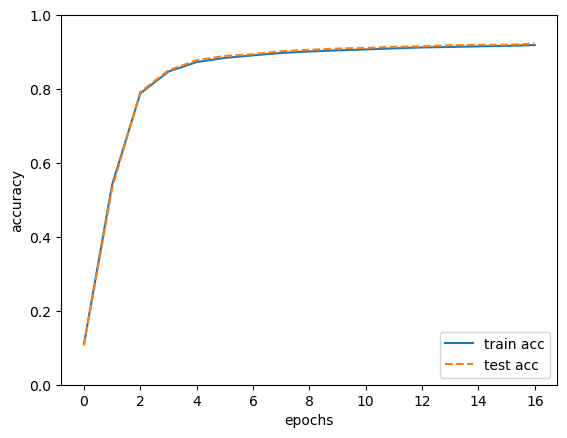

In [4]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

os.chdir(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-master\ch04")
sys.path.append(os.pardir)
from dataset.mnist import load_mnist

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

# ハイパーパラメーター
iters_num = 10000
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.1

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)

network = TwoLayerNet_v3(input_size=784, hidden_size=50, output_size=10)
optimizer = SGD() # <================================前回との相違点

for i in range(iters_num):
    # train_sizeからbatch_size分ランダム選択（インデックス）
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 求めたい微分の変数がh分変化した時、ランダム選択された100個のサンプルの損失平均の変化量（偏微分||接線の傾き）たち（勾配）
    # grads = network.Allnumerical_gradients(x_batch, t_batch) # 数値微分による勾配計算（遅い）
    grads = network.gradient(x_batch, t_batch)  # back propagationを使った高速版
    params = network.params
    optimizer.update(params, grads) #<================================これが下のfor文の代わりになる
    # # それぞれのパラメーターをアップデート
    # for key in ("W1", "b1", "W2", "b2"):
    #     network.params[key] -= learning_rate * grads[key]

    # 1バッチ（100個の損失平均）ごとの記録
    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)
    # print("loss per batch | " + str(loss))

    #1エポック毎に精度を計算しその時のバッチデータで精度を計算し表示する
    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)
        print("train acc, test acc | " + str(train_acc) + ", " + str(test_acc))

# モデルの正確度推移
markers = {"train": "o", "test": "s"}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, label="train acc")
plt.plot(x, test_acc_list, label="test acc", linestyle="--")
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc="lower right")
plt.show()


In [5]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None: #まずvがパラメーター(W1,b1など)と同一の配列データがあるか確認
            self.v = {} #無いなら辞書作成
            for key, val in params.items():
                #それぞれのパラメーターに対して同一な配列を持つvを作成
                self.v[key] = np.zeros_like(val)

        for key in params.keys(): # それぞれのパラーメーターに対して
            # vを更新(過去の勾配情報が蓄積されて同じ方向を指せば加速、逆方向なら減速する)
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            # そのvをパラメーターに加算することで加速的（減速的）な更新が可能
            params[key] += self.v[key]

In [6]:
class AdaGrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None

    def update(self, params, grads):
        # Momentumと流れ一緒（数式とパラメーターの更新方法が異なる）
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)

        for key in params.keys():
            # 勾配の2乗和を求めてhを更新（過去の勾配情報が蓄積されて同じ方向を指すほどhの値が大きくなり、下で学習係数をより小さくする働きをする）
            self.h[key] += grads[key] * grads[key]
            # ルートその２乗和分の１で学習係数をスケールすることで勾配に対する学習係数が小さくなり、パラメーターの更新が小さくなっていく
            # 同じ方向の勾配が蓄積されるほど、その勾配に対応するパラーメータの学習係数が小さくなっていく
            params[key] -= self.lr * (1 / (np.sqrt(self.h[key]) + 1e-7)) * grads[key]

In [7]:
class Adam:
    """Adam (http://arxiv.org/abs/1412.6980v8)"""

    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None

    def update(self, params, grads):
        # momentumやAdaGradと流れは同じ（今回は２つパラーメータ更新を補正する変数があるのと数式とパラメーターの更新方法が異なる）
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)  # 移動（勾配）平均
                self.v[key] = np.zeros_like(val)  # 分散（２乗勾配）平均

        self.iter += 1
        # Adamとは関係ないオプション(初期試行における学習率調整)設定
        # Adamではバイアス補正によって初期段階の勾配がほぼ補正されるが、それでもなお誤った勾配として考え、
        # 初期段階の学習率を下げる補正により「誤った勾配」でのパラメータ更新を抑える（この補正は後半(self.iterが増えるほど)ほぼ無くなる）
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)

        for key in params.keys():
            # 変形前の移動平均と分散平均の式
            # 過去の勾配には９割の重み、現在の勾配には１割の重みを与えた移動（分散）平均を使って滑らかなパラメーター更新が滑らかになる
            # self.m[key] = self.beta1*self.m[key] + (1-self.beta1)*grads[key]　：移動平均
            # self.v[key] = self.beta2*self.v[key] + (1-self.beta2)*(grads[key]**2)　：分散平均

            # 変形後の移動平均と分散平均の式（よりパフォーマンスがよりいいのとシンプルで理解しやすい：理論上結果は変形前と同じ）
            # 現在の勾配と過去の勾配平均との差に１割の重みを与えた移動（分散）平均を使って滑らかなパラメーター更新が滑らかになる
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key] ** 2 - self.v[key])

            # 何故かバイアス補正の実装がコメントアウトされて補正なしでパラメータ更新をしているが本来は必要
            # unbias_m += (1 - self.beta1) * (grads[key] - self.m[key]) # correct bias
            # unbisa_b += (1 - self.beta2) * (grads[key]*grads[key] - self.v[key]) # correct bias
            # params[key] += self.lr * unbias_m / (np.sqrt(unbisa_b) + 1e-7)

            params[key] -= lr_t * self.m[key] / (np.sqrt(self.v[key]) + 1e-7)

In [8]:
# MNISTデータに対するoptimizersの比較

In [9]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class MultiLayerNet:
    """全結合による多層ニューラルネットワーク

    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    weight_decay_lambda : Weight Decay（L2ノルム）の強さ
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        # 隠れレイヤ（Affine + Activation function:今回はRelu）
        for idx in range(1, self.hidden_layer_num+1): #各隠れレイヤ
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        # 出力レイヤ：Affine (+ SoftmaxWithLoss)
        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss() # 推論では使わない（学習時の損失計算で使用）

    def __init_weight(self, weight_init_std):
        """重みの初期値設定

        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size] # e.g. [784, 100, 100, 100, 100, 100, 100, 10]
        for idx in range(1, len(all_size_list)): # 入力以外のレイヤー（隠れと出力レイヤー）
            # 数字(1.0, 0.01など)か文字列(Relu, sigmoid): 数字なら下のif文はスキップ
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値

            #第０から第１レイヤ間のW1とb１, 第１から第２レイヤ間のW2, b2,...における初期値を設定
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        損失関数の値
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2): # 入力以外のレイヤー（隠れと出力レイヤー）
            W = self.params['W' + str(idx)]
            # 全レイヤーのWの全要素におけるペナルティーを合計する（全Wを抑制する）
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)
        # ペナルティの合計を損失に足すことでWの値が増えると損失が上がりやすくなり、モデルがWの値を上げるのを抑制する
        # →過学習(特定のデータになど特化すること)を抑制する
        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1) #行における最大値のインデックスの取得（１次元配列）
        # 正解ラベルがゼロワンデータだった場合（多次元配列）（もともと1次元の場合は0-9で直接答えが書かれている１次元配列）
        if t.ndim != 1 : t = np.argmax(t, axis=1) #各行における最大値のインデックスを取得（１次元配列に変換）

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2): # 入力以外のレイヤー（隠れと出力レイヤー）
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2): # 入力以外のレイヤー（隠れと出力レイヤー）
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads


===========iteration:0===========
SGD:2.421244799291765
Momentum:2.2938461950126072
AdaGrad:2.0644480876921407
Adam:2.2205599794954245
===========iteration:100===========
SGD:1.4775589913094913
Momentum:0.3592015507901945
AdaGrad:0.13944855218771277
Adam:0.2363413623192649
===========iteration:200===========
SGD:0.731167809032832
Momentum:0.20789717911259564
AdaGrad:0.09175118404483515
Adam:0.1389020138009467
===========iteration:300===========
SGD:0.46883465419144005
Momentum:0.10000005871130693
AdaGrad:0.04454674253241145
Adam:0.06157980650866432
===========iteration:400===========
SGD:0.4341485287304535
Momentum:0.1995934008170604
AdaGrad:0.04971521650160647
Adam:0.14260760161451397
===========iteration:500===========
SGD:0.2867203131887846
Momentum:0.1111914040489694
AdaGrad:0.041755297077619505
Adam:0.06377872594718352
===========iteration:600===========
SGD:0.2888512885504907
Momentum:0.1368021789516357
AdaGrad:0.06434294686143364
Adam:0.06244725081919915
===========iteration:700

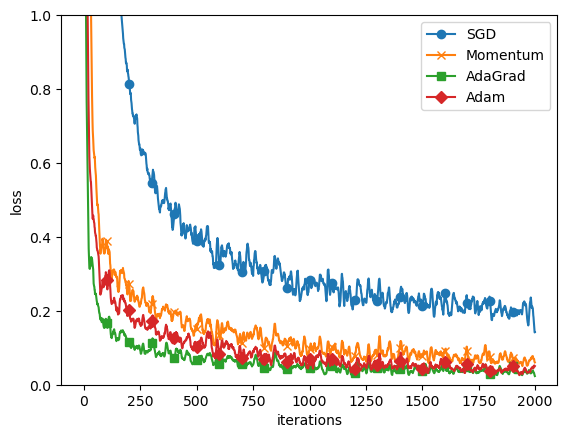

In [10]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {} # モデル(MultiLayerNetクラスのインスタンス)をoptimizer毎に作成し格納する辞書
train_loss = {}
for key in optimizers.keys():
    # optimizers辞書のキーをnetwork辞書に共有する
    networks[key] = MultiLayerNet( # 各optimizerに対してMultiLayerNetクラスのインスタンスを一つずつ作成
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = [] #損失の途中経過を描写するためのリスト


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    for key in optimizers.keys():
        # 一つずつキー（optimizer）に対応するモデルを呼び出して勾配計算
        grads = networks[key].gradient(x_batch, t_batch)
        # キーに対応するoptimizerを使って勾配の更新
        optimizers[key].update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    # 100試行毎に
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        # opimizerそれぞれの現在のバッチデータにおける損失を表示
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()


In [11]:
# Wの初期値設定で異なるSigmoid(tanh)の分布：標準偏差1.0, 0.01, 1/√n, 2/√n（n=前レイヤーのノードの数）

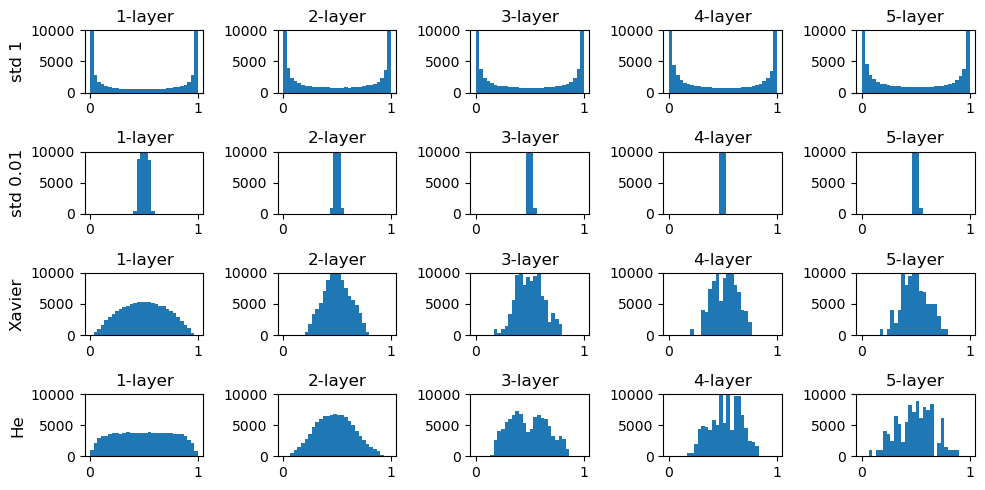

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

# データの生成
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5

# Wの初期化方法の設定(sigmoid, tanhなどのS字カーブにはXavier初期値が最適とされている)
initializations = {
    "std 1": lambda: np.random.randn(node_num, node_num) * 1, #標準偏差1のガウス分布（0,1に偏る＝勾配の消失＆表現力の制限）
    "std 0.01": lambda: np.random.randn(node_num, node_num) * 0.01, #標準偏差0.01のガウス分布（0.5付近に偏る＝表現力の制限）
    "Xavier": lambda: np.random.randn(node_num, node_num) / np.sqrt(node_num), # 標準偏差1/√n（Xavier）のガウス分布（n=前レイヤーのノードの数）
    "He": lambda: np.random.randn(node_num, node_num) * np.sqrt(2 / node_num) #：標準偏差2/√n（He）のガウス分布（n=前レイヤーのノードの数）
}

# プロット画像の大きさ（横縦）設定
plt.figure(figsize=(10, 5))

for idx, (name, init_func) in enumerate(initializations.items()):
    activations = {}
    x_input = x

    for i in range(hidden_layer_size):
        if i != 0:
            x_input = activations[i-1]  # 一つ前のレイヤーの出力を現在のレイヤー入力として獲得

        w = init_func()  # 各初期化方法に従った重み行列を取得

        z = np.dot(x_input, w)
        a = sigmoid(z)
        activations[i] = a

    for i, a in activations.items():
        # 1つの図に複数のプロット（サブプロット）を配置するための関数(縦, 横, 位置)
        # 左から右に数えていく形式で位置を特定
        # e.g. 4×5複数のプロット対し1行目１列目のプロットなら、まず0行目の5個(1*5:１行目だから０行目は確定で全部)数えて1列目だから+１で２個数えて７になる）
        plt.subplot(len(initializations), hidden_layer_size, idx * hidden_layer_size + i + 1)
        if i == 0:
            plt.ylabel(name, fontsize=12)
        plt.title(str(i+1) + "-layer")
        plt.hist(a.flatten(), 30, range=(0,1))
        plt.ylim(0, 10000)  # Y軸の上限を7000に設定

plt.tight_layout()
plt.show()


In [13]:
# Wの初期値設定で異なるReluの分布：標準偏差1.0, 0.01, 1/√n, 2/√n（n=前レイヤーのノードの数）

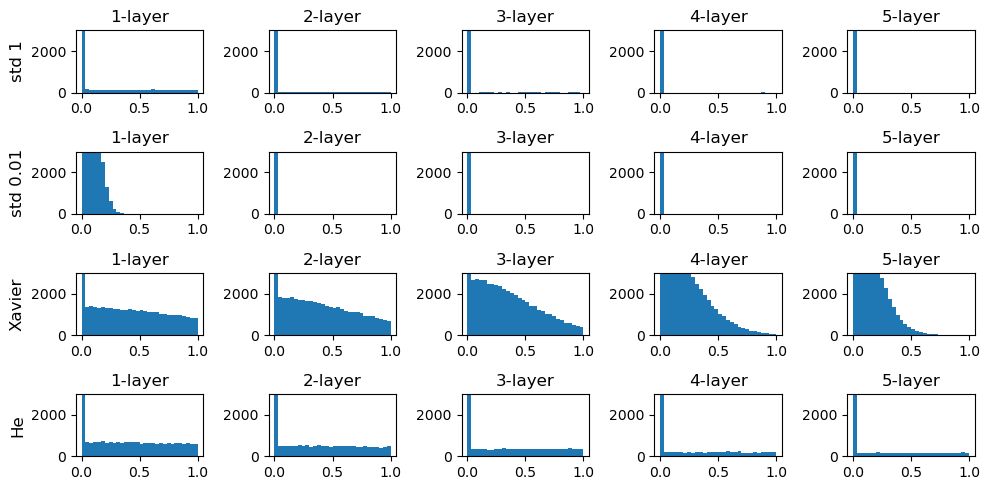

In [14]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys

os.chdir(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-master\ch04")
sys.path.append(os.pardir)
from common.functions import relu

# データの生成
x = np.random.randn(1000, 100)
node_num = 100
hidden_layer_size = 5

# Wの初期化方法の設定(ReLuにはHe初期値が最適とされている)
initializations = {
    "std 1": lambda: np.random.randn(node_num, node_num) * 1,
    "std 0.01": lambda: np.random.randn(node_num, node_num) * 0.01,
    "Xavier": lambda: np.random.randn(node_num, node_num) * (1 / np.sqrt(node_num)),
    "He": lambda: np.random.randn(node_num, node_num) * (2 / np.sqrt(node_num))
}

# プロットの設定
plt.figure(figsize=(10, 5))

for idx, (name, init_func) in enumerate(initializations.items()):
    activations = {}
    x_input = x

    for i in range(hidden_layer_size):
        if i != 0:
            x_input = activations[i-1] # 一つ前のレイヤーの出力を現在のレイヤー入力として獲得

        w = init_func()  # 各初期化方法に従った重み行列を取得

        z = np.dot(x_input, w)
        a = relu(z)
        activations[i] = a

    for i, a in activations.items():
        plt.subplot(len(initializations), hidden_layer_size, idx * hidden_layer_size + i + 1)
        if i == 0:
            plt.ylabel(name, fontsize=12)
        plt.title(str(i+1) + "-layer")
        plt.hist(a.flatten(), 30, range=(0,1))
        plt.ylim(0, 3000)  # Y軸の上限を7000に設定

plt.tight_layout()
plt.show()


In [15]:
#MNISTデータに対するW初期値の比較(Relu)

In [16]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class MultiLayerNet:
    """全結合による多層ニューラルネットワーク

    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    weight_decay_lambda : Weight Decay（L2ノルム）の強さ
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        # 隠れレイヤ（Affine + Activation function:今回はRelu）
        for idx in range(1, self.hidden_layer_num+1): #各隠れレイヤ
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        # 出力レイヤ：Affine (+ SoftmaxWithLoss)
        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss() # 推論では使わない（学習時の損失計算で使用）

    def __init_weight(self, weight_init_std):
        """重みの初期値設定

        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size] # e.g. [784, 100, 100, 100, 100, 100, 100, 10]
        for idx in range(1, len(all_size_list)): # 入力以外のレイヤー（隠れと出力レイヤー）
            # 数字(1.0, 0.01など)か文字列(Relu, sigmoid): 数字なら下のif文はスキップ
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値

            #第０から第１レイヤ間のW1とb１, 第１から第２レイヤ間のW2, b2,...における初期値を設定
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        損失関数の値
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2): # 入力以外のレイヤー（隠れと出力レイヤー）
            W = self.params['W' + str(idx)]
            # 全レイヤーのWの全要素におけるペナルティーを合計する（全Wを抑制する）
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)
        # ペナルティの合計を損失に足すことでWの値が増えると損失が上がりやすくなり、モデルがWの値を上げるのを抑制する
        # →過学習(特定のデータになど特化すること)を抑制する
        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1) #行における最大値のインデックスの取得（１次元配列）
        # 正解ラベルがゼロワンデータだった場合（多次元配列）（もともと1次元の場合は0-9で直接答えが書かれている１次元配列）
        if t.ndim != 1 : t = np.argmax(t, axis=1) #各行における最大値のインデックスを取得（１次元配列に変換）

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2): # 入力以外のレイヤー（隠れと出力レイヤー）
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2): # 入力以外のレイヤー（隠れと出力レイヤー）
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads


===========iteration:0===========
std=0.01:2.302497400990263
Xavier:2.310160643405687
He:2.321471337887633
===========iteration:100===========
std=0.01:2.3024076578198605
Xavier:2.270741512134329
He:1.46013456928852
===========iteration:200===========
std=0.01:2.3027465366409343
Xavier:2.214318261598849
He:0.7593351579101447
===========iteration:300===========
std=0.01:2.3027601692545616
Xavier:2.1080735814144207
He:0.5199195298712329
===========iteration:400===========
std=0.01:2.303668023308634
Xavier:1.8491808177457318
He:0.31142731401105594
===========iteration:500===========
std=0.01:2.3016656855018756
Xavier:1.3180417596585121
He:0.41811666544280734
===========iteration:600===========
std=0.01:2.3003370747977976
Xavier:0.9279470076098278
He:0.2673978433954233
===========iteration:700===========
std=0.01:2.298930966490651
Xavier:0.7425359867935554
He:0.4213546479299262
===========iteration:800===========
std=0.01:2.2972523151865616
Xavier:0.6371864974406882
He:0.2909407488280146
=

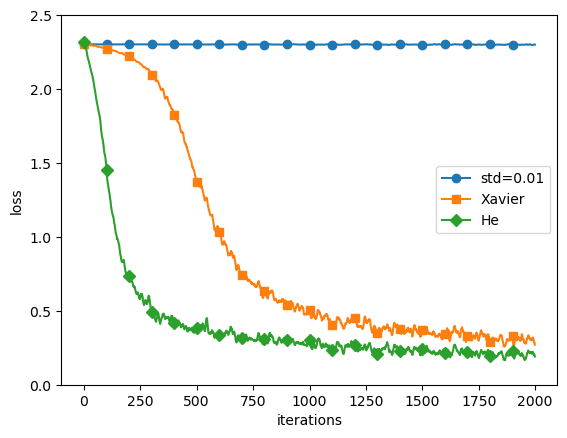

In [17]:
# coding: utf-8
import os
import sys

os.chdir(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-master\ch04")
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:MNISTデータの読み込み==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:実験の設定==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items(): # weight_init_types（初期値設定）のキーをnetworkに共有
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = [] # 初期値設定ごとの損失を記録するリストを作成


# 2:訓練の開始==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    # 各初期値設定に対応するモデルを呼び出し各計算をする
    for key in weight_init_types.keys(): # 各初期値設定
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)

        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)

    # 100試行毎に
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        # 各初期値設定に対応するモデルの損失を表示
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.グラフの描画==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

In [18]:
# 過学習の抑制方法(Weight decay)

In [19]:
# coding: utf-8
import sys, os
os.chdir(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-master\ch04")
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class MultiLayerNet:
    """全結合による多層ニューラルネットワーク

    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    weight_decay_lambda : Weight Decay（L2ノルム）の強さ
    """
    def __init__(self, input_size, hidden_size_list, output_size,
                 activation='relu', weight_init_std='relu', weight_decay_lambda=0):
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.weight_decay_lambda = weight_decay_lambda
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {'sigmoid': Sigmoid, 'relu': Relu}
        self.layers = OrderedDict()
        # 隠れレイヤ（Affine + Activation function:今回はRelu）
        for idx in range(1, self.hidden_layer_num+1): #各隠れレイヤ
            self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
                                                      self.params['b' + str(idx)])
            self.layers['Activation_function' + str(idx)] = activation_layer[activation]()

        # 出力レイヤ：Affine (+ SoftmaxWithLoss)
        idx = self.hidden_layer_num + 1
        self.layers['Affine' + str(idx)] = Affine(self.params['W' + str(idx)],
            self.params['b' + str(idx)])

        self.last_layer = SoftmaxWithLoss() # 推論では使わない（学習時の損失計算で使用）

    def __init_weight(self, weight_init_std):
        """重みの初期値設定

        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = [self.input_size] + self.hidden_size_list + [self.output_size] # e.g. [784, 100, 100, 100, 100, 100, 100, 10]
        for idx in range(1, len(all_size_list)): # 入力以外のレイヤー（隠れと出力レイヤー）
            # 数字(1.0, 0.01など)か文字列(Relu, sigmoid): 数字なら下のif文はスキップ
            scale = weight_init_std
            if str(weight_init_std).lower() in ('relu', 'he'):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ('sigmoid', 'xavier'):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値

            #第０から第１レイヤ間のW1とb１, 第１から第２レイヤ間のW2, b2,...における初期値を設定
            self.params['W' + str(idx)] = scale * np.random.randn(all_size_list[idx-1], all_size_list[idx])
            self.params['b' + str(idx)] = np.zeros(all_size_list[idx])

    def predict(self, x):
        for layer in self.layers.values():
            x = layer.forward(x)

        return x

    def loss(self, x, t):
        """損失関数を求める

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        損失関数の値
        """
        y = self.predict(x)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2): # 入力以外のレイヤー（隠れと出力レイヤー）
            W = self.params['W' + str(idx)]
            # 全レイヤーのWの全要素におけるペナルティーを合計する（全Wを抑制する）
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W ** 2)
        # ペナルティの合計を損失に足すことでWの値が増えると損失が上がりやすくなり、モデルがWの値を上げるのを抑制する
        # →過学習(特定のデータになど特化すること)を抑制する
        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1) #行における最大値のインデックスの取得（１次元配列）
        # 正解ラベルがゼロワンデータだった場合（多次元配列）（もともと1次元の場合は0-9で直接答えが書かれている１次元配列）
        if t.ndim != 1 : t = np.argmax(t, axis=1) #各行における最大値のインデックスを取得（１次元配列に変換）

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        loss_W = lambda W: self.loss(x, t)

        grads = {}
        for idx in range(1, self.hidden_layer_num+2): # 入力以外のレイヤー（隠れと出力レイヤー）
            grads['W' + str(idx)] = numerical_gradient(loss_W, self.params['W' + str(idx)])
            grads['b' + str(idx)] = numerical_gradient(loss_W, self.params['b' + str(idx)])

        return grads

    def gradient(self, x, t):
        """勾配を求める（誤差逆伝搬法）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # forward
        self.loss(x, t)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num+2): # 入力以外のレイヤー（隠れと出力レイヤー）
            grads['W' + str(idx)] = self.layers['Affine' + str(idx)].dW + self.weight_decay_lambda * self.layers['Affine' + str(idx)].W
            grads['b' + str(idx)] = self.layers['Affine' + str(idx)].db

        return grads


In [20]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt

os.chdir(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-master\ch04")
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

def train_and_evaluate(weight_decay_lambda, max_epochs=201):
    (x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

    # 過学習を再現するために、学習データを削減
    x_train = x_train[:300]
    t_train = t_train[:300]

    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                            weight_decay_lambda=weight_decay_lambda)
    optimizer = SGD(lr=0.01)

    train_size = x_train.shape[0]
    batch_size = 100

    train_acc_list = []
    test_acc_list = []

    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0

    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]

        grads = network.gradient(x_batch, t_batch)
        optimizer.update(network.params, grads)

        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            test_acc = network.accuracy(x_test, t_test)
            train_acc_list.append(train_acc)
            test_acc_list.append(test_acc)

            print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break

    return train_acc_list, test_acc_list

# Weight decay を使わない場合
train_acc_list_0, test_acc_list_0 = train_and_evaluate(weight_decay_lambda=0)

# Weight decay を使う場合
train_acc_list_01, test_acc_list_01 = train_and_evaluate(weight_decay_lambda=0.1)

# 3. グラフの描画
x = np.arange(201)

plt.figure(figsize=(12, 5))

# グラフ 1: Weight decay を使わない場合
plt.subplot(1, 2, 1)
plt.plot(x, train_acc_list_0, marker='o', label='train (wd=0)', markevery=10)
plt.plot(x, test_acc_list_0, marker='s', label='test (wd=0)', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title('Weight Decay = 0')

# グラフ 2: Weight decay を使う場合
plt.subplot(1, 2, 2)
plt.plot(x, train_acc_list_01, marker='o', label='train (wd=0.1)', markevery=10)
plt.plot(x, test_acc_list_01, marker='s', label='test (wd=0.1)', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.title('Weight Decay = 0.1')

plt.tight_layout()
plt.show()


epoch:0, train acc:0.12333333333333334, test acc:0.1213
epoch:1, train acc:0.14333333333333334, test acc:0.1339
epoch:2, train acc:0.15333333333333332, test acc:0.1441
epoch:3, train acc:0.16666666666666666, test acc:0.1632
epoch:4, train acc:0.18333333333333332, test acc:0.1699
epoch:5, train acc:0.19333333333333333, test acc:0.1804
epoch:6, train acc:0.21, test acc:0.183
epoch:7, train acc:0.22, test acc:0.1862
epoch:8, train acc:0.24666666666666667, test acc:0.1948
epoch:9, train acc:0.2633333333333333, test acc:0.2042
epoch:10, train acc:0.2733333333333333, test acc:0.2139
epoch:11, train acc:0.2866666666666667, test acc:0.225
epoch:12, train acc:0.31, test acc:0.2386
epoch:13, train acc:0.33666666666666667, test acc:0.2503
epoch:14, train acc:0.3566666666666667, test acc:0.2687
epoch:15, train acc:0.3566666666666667, test acc:0.2754
epoch:16, train acc:0.37333333333333335, test acc:0.2843
epoch:17, train acc:0.38333333333333336, test acc:0.2927
epoch:18, train acc:0.40666666666666

In [ ]:
# 過学習の抑制法(Dropout)

In [ ]:
class Dropout:
    """
    http://arxiv.org/abs/1207.0580
    """
    def __init__(self, dropout_ratio=0.5):
        self.dropout_ratio = dropout_ratio
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            # ｘ同じ形状の0-1の数字をランダムに生成,self.dropout_ratioより大きいものだけTrue
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio
            # True以外は０になる：学習時の入力(出力)が(1.0 - self.dropout_ratio)倍になる
            return x * self.mask
        else: # テスト時
            # 学習時の入力に合わせるためテスト時の入力(出力)を(1.0 - self.dropout_ratio)倍する
            return x * (1.0 - self.dropout_ratio)

    # Reluと同じ
    def backward(self, dout):
        return dout * self.mask

In [ ]:
# coding: utf-8
import sys, os
os.chdir(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-master\ch04")
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common.optimizer import *


class Trainer:
    """ニューラルネットの訓練を行うクラス"""

    def __init__(
        self,
        network,
        x_train,
        t_train,
        x_test,
        t_test,
        epochs=20,
        mini_batch_size=100,
        optimizer="SGD",
        optimizer_param={"lr": 0.01},
        evaluate_sample_num_per_epoch=None,
        verbose=True,
    ):
        self.network = network
        self.verbose = verbose  # 途中経過を出力するかどうかのスイッチ
        self.x_train = x_train
        self.t_train = t_train
        self.x_test = x_test
        self.t_test = t_test
        self.epochs = epochs
        self.batch_size = mini_batch_size
        self.evaluate_sample_num_per_epoch = evaluate_sample_num_per_epoch

        # optimizer
        optimizer_class_dict = {
            "sgd": SGD,
            "momentum": Momentum,
            "nesterov": Nesterov,
            "adagrad": AdaGrad,
            "rmsprop": RMSprop,
            "adam": Adam,
        }
        # optimizer_param('lr':0.01)を引数として辞書から呼ばれたoptimizerに代入
        self.optimizer = optimizer_class_dict[optimizer.lower()](**optimizer_param)

        self.train_size = x_train.shape[0]
        self.iter_per_epoch = max(int(self.train_size / mini_batch_size), 1)
        self.max_iter = int(epochs * self.iter_per_epoch)
        self.current_iter = 0
        self.current_epoch = 0

        self.train_loss_list = []
        self.train_acc_list = []
        self.test_acc_list = []

    # １回分の学習試行
    def train_step(self):
        batch_mask = np.random.choice(self.train_size, self.batch_size)
        x_batch = self.x_train[batch_mask]
        t_batch = self.t_train[batch_mask]

        grads = self.network.gradient(x_batch, t_batch)
        self.optimizer.update(self.network.params, grads)

        loss = self.network.loss(x_batch, t_batch)
        self.train_loss_list.append(loss)
        self.current_iter += 1
        if self.verbose:
            print("No. " + str(self.current_iter) + " train loss:" + str(loss))

        # 1エポック分完了した時
        if self.current_iter % self.iter_per_epoch == 0:
            self.current_epoch += 1
            # デフォルトでは全体データをサンプルデータに格納
            x_train_sample, t_train_sample = self.x_train, self.t_train
            x_test_sample, t_test_sample = self.x_test, self.t_test
            # もし精度評価するデータ数tの設定があるなら
            if not self.evaluate_sample_num_per_epoch is None:
                t = self.evaluate_sample_num_per_epoch
                # 全体データの先頭からt個分サンプリング
                x_train_sample, t_train_sample = self.x_train[:t], self.t_train[:t]
                x_test_sample, t_test_sample = self.x_test[:t], self.t_test[:t]
            # 全体もしくは指定数のサンプリングの精度評価しリストに記録
            train_acc = self.network.accuracy(x_train_sample, t_train_sample)
            test_acc = self.network.accuracy(x_test_sample, t_test_sample)
            self.train_acc_list.append(train_acc)
            self.test_acc_list.append(test_acc)

            if self.verbose:
                print(
                    "=== epoch:"
                    + str(self.current_epoch)
                    + ", train acc:"
                    + str(train_acc)
                    + ", test acc:"
                    + str(test_acc)
                    + " ==="
                )

    def train(self):
        for i in range(self.max_iter):
            self.train_step()

        test_acc = self.network.accuracy(self.x_test, self.t_test)

        if self.verbose:
            print("=============== Final Test Accuracy ===============")
            print("test acc:" + str(test_acc))


In [ ]:
# coding: utf-8
import sys, os
os.chdir(r"C:\Users\jiwon\OneDrive\Desktop\deep-learning-from-scratch-master\ch04")
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from collections import OrderedDict
from common.layers import *
from common.gradient import numerical_gradient


class MultiLayerNetExtend:
    """拡張版の全結合による多層ニューラルネットワーク

    Weiht Decay、Dropout、Batch Normalizationの機能を持つ

    Parameters
    ----------
    input_size : 入力サイズ（MNISTの場合は784）
    hidden_size_list : 隠れ層のニューロンの数のリスト（e.g. [100, 100, 100]）
    output_size : 出力サイズ（MNISTの場合は10）
    activation : 'relu' or 'sigmoid'
    weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
        'relu'または'he'を指定した場合は「Heの初期値」を設定
        'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
    weight_decay_lambda : Weight Decay（L2ノルム）の強さ
    use_dropout: Dropoutを使用するかどうか
    dropout_ration : Dropoutの割り合い
    use_batchNorm: Batch Normalizationを使用するかどうか
    """

    def __init__(
        self,
        input_size,
        hidden_size_list,
        output_size,
        activation="relu",
        weight_init_std="relu",
        weight_decay_lambda=0,
        use_dropout=False,
        dropout_ration=0.5,
        use_batchnorm=False,
    ):
        self.input_size = input_size
        self.hidden_size_list = hidden_size_list
        self.hidden_layer_num = len(hidden_size_list)
        self.output_size = output_size
        self.weight_decay_lambda = weight_decay_lambda
        self.use_dropout = use_dropout
        self.use_batchnorm = use_batchnorm
        self.params = {}

        # 重みの初期化
        self.__init_weight(weight_init_std)

        # レイヤの生成
        activation_layer = {"sigmoid": Sigmoid, "relu": Relu}
        self.layers = OrderedDict()
        # 隠れレイヤ（Affine + Activation function:今回はRelu）
        for idx in range(1, self.hidden_layer_num + 1):
            self.layers["Affine" + str(idx)] = Affine(self.params["W" + str(idx)], self.params["b" + str(idx)])
            if self.use_batchnorm:
                self.params["gamma" + str(idx)] = np.ones(hidden_size_list[idx - 1])
                self.params["beta" + str(idx)] = np.zeros(hidden_size_list[idx - 1])
                self.layers["BatchNorm" + str(idx)] = BatchNormalization(
                    self.params["gamma" + str(idx)], self.params["beta" + str(idx)]
                )

            self.layers["Activation_function" + str(idx)] = activation_layer[activation]()

            if self.use_dropout:
                self.layers["Dropout" + str(idx)] = Dropout(dropout_ration)

        # 出力レイヤ：Affine (+ SoftmaxWithLoss)
        idx = self.hidden_layer_num + 1
        self.layers["Affine" + str(idx)] = Affine(self.params["W" + str(idx)], self.params["b" + str(idx)])

        self.last_layer = SoftmaxWithLoss()

    def __init_weight(self, weight_init_std):
        """重みの初期値設定

        Parameters
        ----------
        weight_init_std : 重みの標準偏差を指定（e.g. 0.01）
            'relu'または'he'を指定した場合は「Heの初期値」を設定
            'sigmoid'または'xavier'を指定した場合は「Xavierの初期値」を設定
        """
        all_size_list = (
            [self.input_size] + self.hidden_size_list + [self.output_size]
        )  # e.g. [784, 100, 100, 100, 100, 100, 100, 10]
        for idx in range(1, len(all_size_list)):  # idx番目のWとb(隠れレイヤから出力レイヤn一致)
            # 数字(1.0, 0.01など)か文字列(Relu, sigmoid): 数字なら下のif文はスキップ
            scale = weight_init_std
            if str(weight_init_std).lower() in ("relu", "he"):
                scale = np.sqrt(2.0 / all_size_list[idx - 1])  # ReLUを使う場合に推奨される初期値
            elif str(weight_init_std).lower() in ("sigmoid", "xavier"):
                scale = np.sqrt(1.0 / all_size_list[idx - 1])  # sigmoidを使う場合に推奨される初期値
            # 第０から第１レイヤ間のW1とb１, 第１から第２レイヤ間のW2, b2,...における初期値を設定
            self.params["W" + str(idx)] = scale * np.random.randn(all_size_list[idx - 1], all_size_list[idx])
            self.params["b" + str(idx)] = np.zeros(all_size_list[idx])

    # 推論ではモデルの全力を見るためdropoutは使わないからデフォルトでtrain_flg=False
    # (学習時の勾配計算(gradient, numerical_gradient)では過学習抑制のために使うloss内ではTrueになる)
    def predict(self, x, train_flg=False):
        for key, layer in self.layers.items():
            if "Dropout" in key or "BatchNorm" in key:
                x = layer.forward(x, train_flg)
            else:
                x = layer.forward(x)

        return x

    # 損失計算ではモデルの全力を見るためdropoutは使わないからデフォルトでtrain_flg=False
    # (学習時の勾配計算(gradient, numeical_gradient)では過学習抑制のために使うloss内ではtrain_flg=Trueになる)
    def loss(self, x, t, train_flg=False):
        """損失関数を求める
        引数のxは入力データ、tは教師ラベル
        """
        y = self.predict(x, train_flg)

        weight_decay = 0
        for idx in range(1, self.hidden_layer_num + 2):  # idx番目のW(隠れレイヤから出力レイヤに一致)
            W = self.params["W" + str(idx)]
            # 全Wにおけるペナルティの合計
            weight_decay += 0.5 * self.weight_decay_lambda * np.sum(W**2)

        return self.last_layer.forward(y, t) + weight_decay

    def accuracy(self, x, t):
        y = self.predict(x)
        y = np.argmax(y, axis=1)  # 行における最大値のインデックスの取得（１次元配列）
        # 正解ラベルがゼロワンデータだった場合（多次元配列）（もともと1次元の場合は0-9で直接答えが書かれている１次元配列）
        if t.ndim != 1:
            t = np.argmax(t, axis=1)  # 各行における最大値のインデックスを取得（１次元配列に変換）

        accuracy = np.sum(y == t) / float(x.shape[0])
        return accuracy

    def numerical_gradient(self, x, t):
        """勾配を求める（数値微分）

        Parameters
        ----------
        x : 入力データ
        t : 教師ラベル

        Returns
        -------
        各層の勾配を持ったディクショナリ変数
            grads['W1']、grads['W2']、...は各層の重み
            grads['b1']、grads['b2']、...は各層のバイアス
        """
        # numerical_gradient内だから学習(パラメータ更新)：ドロップアウトを適用し、過学習を抑制しつつパラメータ更新
        loss_W = lambda W: self.loss(x, t, train_flg=True)

        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):
            grads["W" + str(idx)] = numerical_gradient(loss_W, self.params["W" + str(idx)])
            grads["b" + str(idx)] = numerical_gradient(loss_W, self.params["b" + str(idx)])

            if self.use_batchnorm and idx != self.hidden_layer_num + 1:  # 出力レイヤ以外なら
                grads["gamma" + str(idx)] = numerical_gradient(loss_W, self.params["gamma" + str(idx)])
                grads["beta" + str(idx)] = numerical_gradient(loss_W, self.params["beta" + str(idx)])

        return grads

    # gradient内だから学習(パラメータ更新)：ドロップアウトを適用し、過学習を抑制しつつパラメータ更新
    def gradient(self, x, t):
        # forward
        self.loss(x, t, train_flg=True)

        # backward
        dout = 1
        dout = self.last_layer.backward(dout)

        layers = list(self.layers.values())
        layers.reverse()
        for layer in layers:
            dout = layer.backward(dout)

        # 設定
        grads = {}
        for idx in range(1, self.hidden_layer_num + 2):  # 隠れレイヤから出力レイヤまで
            grads["W" + str(idx)] = (
                # 損失関数で全Wのペナルティの合計を足したから,
                self.layers["Affine" + str(idx)].dW
                # 各Wの勾配(微分)を求める時は各Wのペナルティにおける微分（λW）も足す
                + self.weight_decay_lambda * self.params["W" + str(idx)]
            )
            grads["b" + str(idx)] = self.layers["Affine" + str(idx)].db

            if self.use_batchnorm and idx != self.hidden_layer_num + 1:
                grads["gamma" + str(idx)] = self.layers["BatchNorm" + str(idx)].dgamma
                grads["beta" + str(idx)] = self.layers["BatchNorm" + str(idx)].dbeta

        return grads


No. 1 train loss:2.4328222471695624
No. 2 train loss:2.368347742128559
No. 3 train loss:2.2950032682963633
=== epoch:1, train acc:0.07666666666666666, test acc:0.0891 ===
No. 4 train loss:2.376275816218099
No. 5 train loss:2.293594598865278
No. 6 train loss:2.294047686389106
=== epoch:2, train acc:0.09333333333333334, test acc:0.0924 ===
No. 7 train loss:2.260263982814798
No. 8 train loss:2.274315311169378
No. 9 train loss:2.239375887430666
=== epoch:3, train acc:0.10333333333333333, test acc:0.1057 ===
No. 10 train loss:2.241344444155959
No. 11 train loss:2.2077963301975796
No. 12 train loss:2.2427890660489878
=== epoch:4, train acc:0.13333333333333333, test acc:0.1289 ===
No. 13 train loss:2.1913548886016696
No. 14 train loss:2.200000315259663
No. 15 train loss:2.2301971564847287
=== epoch:5, train acc:0.19666666666666666, test acc:0.1637 ===
No. 16 train loss:2.1682591058122718
No. 17 train loss:2.2374893663119924
No. 18 train loss:2.1888690798899453
=== epoch:6, train acc:0.2566666

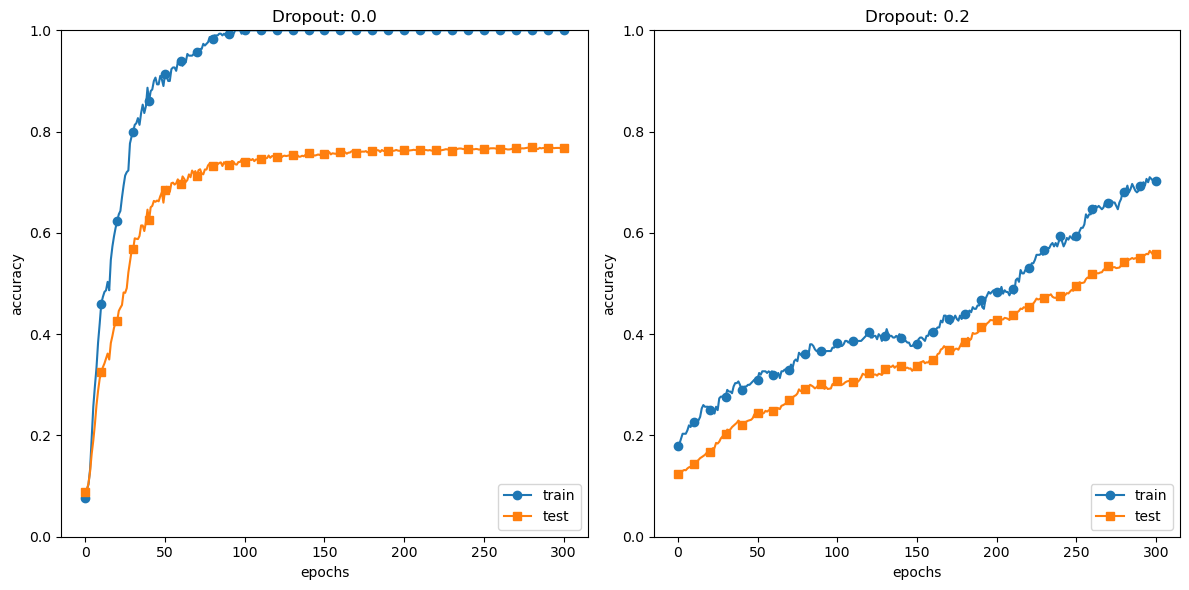

In [ ]:
import os
import sys
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
# from common.multi_layer_net_extend import MultiLayerNetExtend
# from common.trainer import Trainer

# データセットの読み込み
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 過学習を再現するために、学習データを削減
x_train = x_train[:300]
t_train = t_train[:300]

# 訓練結果を保存するリスト
results = {}

# Dropoutの設定のリスト
dropout_settings = [(False, 0.0), (True, 0.2)]

for use_dropout, dropout_ratio in dropout_settings:
    # ネットワークの構築
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                                  output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
    # トレーナーの設定
    trainer = Trainer(network, x_train, t_train, x_test, t_test,
                      epochs=301, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
    # 訓練の実行
    trainer.train()

    # 結果を保存
    key = f"dropout_{use_dropout}" # use_dropoutがTrueなら”dろぽうt＿True”、Falseなら"dropout_False"
    results[key] = { #ドロップアウトあり・なしをキーにして、
        # さらにそれぞれにおける学習・テストをキーにしてに精度のデータリストを格納
        'train_acc': trainer.train_acc_list,
        'test_acc': trainer.test_acc_list
    }

# グラフの描画
markers = {'train': 'o', 'test': 's'}
# 必要なキーを連ねて値にアクセス
x = np.arange(len(results['dropout_False']['train_acc']))

plt.figure(figsize=(12, 6))

# Dropoutなしのグラフ
plt.subplot(1, 2, 1)
plt.plot(x, results['dropout_False']['train_acc'], marker='o', label='train', markevery=10)
plt.plot(x, results['dropout_False']['test_acc'], marker='s', label='test', markevery=10)
plt.title('Dropout: 0.0')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')

# Dropoutありのグラフ
plt.subplot(1, 2, 2)
plt.plot(x, results['dropout_True']['train_acc'], marker='o', label='train', markevery=10)
plt.plot(x, results['dropout_True']['test_acc'], marker='s', label='test', markevery=10)
plt.title('Dropout: 0.2')
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


In [ ]:
# ハイパーパラメータの選択方法

No. 0 HyperParameters | lr:1.7122297718268007e-06, weight decay:1.1486059317243595e-07 | val acc:0.17
No. 1 HyperParameters | lr:5.4840670873647566e-05, weight decay:6.842901852666488e-05 | val acc:0.12
No. 2 HyperParameters | lr:1.3032129729452315e-06, weight decay:2.30495000978764e-05 | val acc:0.1
No. 3 HyperParameters | lr:5.422983721889473e-06, weight decay:3.192674908153045e-05 | val acc:0.06
No. 4 HyperParameters | lr:0.006329567847349411, weight decay:3.387465296802299e-05 | val acc:0.7
No. 5 HyperParameters | lr:0.0007579313832778538, weight decay:1.1764185051585638e-07 | val acc:0.22
No. 6 HyperParameters | lr:1.2011776536858403e-05, weight decay:9.261230620433076e-07 | val acc:0.06
No. 7 HyperParameters | lr:0.002001609070337348, weight decay:3.4341296369994504e-06 | val acc:0.45
No. 8 HyperParameters | lr:4.855653412266014e-05, weight decay:1.0420137060638504e-07 | val acc:0.07
No. 9 HyperParameters | lr:0.002641332437110923, weight decay:1.5296647178963484e-06 | val acc:0.

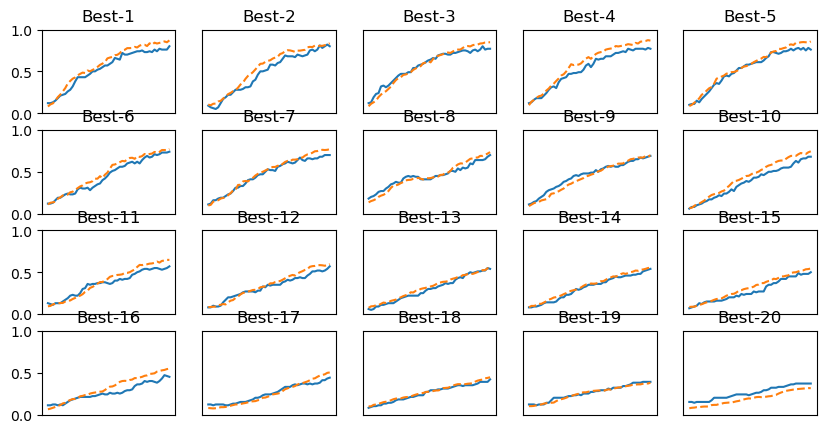

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
import matplotlib.pyplot as plt
from dataset.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 高速化のため訓練データの削減
x_train = x_train[:500]
t_train = t_train[:500]

# 検証データの分離
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# ハイパーパラメータのランダム探索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for i in range(optimization_trial): # 100回ハイパーパラメータを指定の範囲内でランダム選択し、それぞれ１００エポック分学習し検証データで精度計算
    # 探索したハイパーパラメータの範囲を指定===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("No. " + str(i) + " HyperParameters" + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay) + " | val acc:" + str(val_acc_list[-1]) ) #[-1]は一番最後の要素
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay) # 各ハイパーパラーメータのペアをキーにし
    # ペアに対する検証と学習時の精度データを格納
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# グラフの描画========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num)) #ceilは切り上げ：グラフの数に対し十分な場所を確保するため
i = 0


plt.figure(figsize=(10, 5))

    # key=lambda x:x[1][-1]とは、辞書のキーと値(タプル)のうち、値[1]（リスト）の最後([-1])の要素
    # ("lr:0.0001, weight decay:0.001", [0.05, 0.1, 0.15, 0.2]),
    # ("lr:0.001, weight decay:0.0001", [0.1, 0.2, 0.3, 0.4]),
    # ("lr:0.01, weight decay:0.00001", [0.2, 0.3, 0.4, 0.5])
    # [0.2, 0.4, 0.5]を基準(key)にソートする
for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True): # ここでのsorted()内のkeyはソートの基準であり、for文のkeyと無関係
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([]) # 0と５の倍数の時y軸メモリ非表示
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()
